In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
from config import gkey
gmaps.configure(api_key=gkey)


In [2]:
mta = pd.read_csv("Resources/mta_station.csv")
df = pd.read_csv("Resources/final_house_data.csv")
df = df[df['distance_miles']<0.15]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


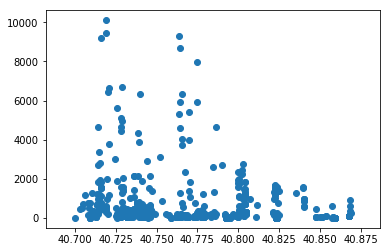

In [3]:
M_df = df[(df['lotSizeSqFt'] != 0) & (df['Borough'] == "M")]
M_df['price per sqft'] = M_df['price'] / M_df['lotSizeSqFt']
# df = df[df['price per sqft'] < 6000]
plt.scatter(M_df['latitude'], M_df['price per sqft'])

plt.title("Price")
# z = np.polyfit(M_df['latitude'], M_df['price per sqft'], 3)
# p = np.poly1d(z)
# plt.plot(M_df['latitude'],p(M_df['latitude']),"r--")

plt.show()

In [4]:
df['price'] = df['price']/1000000

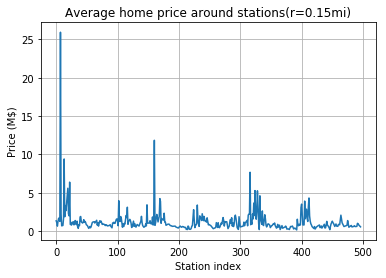

In [5]:
avg_price_per_station = df.groupby('Nearest Station Index')['price'].mean().plot()
avg_price_per_station.set_title("Average home price around stations(r=0.15mi)")
avg_price_per_station.set_xlabel("Station index")
avg_price_per_station.set_ylabel("Price (M$)")
avg_price_per_station.grid()
avg_price_per_station.figure.savefig("Resources/Images/Average home price around all station.png")

In [6]:
from operator import methodcaller
mta['line'] = list(map(methodcaller("split", " "), mta["Daytime Routes"]))
mta['line count'] =  list(map(len, mta["line"]))
mta['line count'].unique()


array([2, 3, 4, 1])

In [7]:
from scipy.spatial import distance

matr = distance.cdist(
        mta[['GTFS Latitude', 'GTFS Longitude']],
        mta[['GTFS Latitude', 'GTFS Longitude']],
        metric = 'euclidean')
distance_df = pd.DataFrame(matr, index=mta['Unnamed: 0'], columns=mta['Unnamed: 0'])
arr = distance_df.values
mta['same Index']  = [list(i).index(np.min(i[np.nonzero(i)])) for i in arr]

from math import sin, cos, sqrt, atan2, radians

def convert_latlon(row):
    R = 6373.0
    
    stoplat = radians(row['GTFS Latitude'])
    stoplon = radians(row['GTFS Longitude'])
    
    homelat = radians(mta.loc[row['same Index'], 'GTFS Latitude'])
    homelon = radians(mta.loc[row['same Index'], 'GTFS Longitude'])
    
    dlon = homelon - stoplon
    dlat = homelat - stoplat
    
    a = sin(dlat / 2)**2 + cos(stoplat) * cos(homelat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance_km = R * c
    distance_m = distance_km * 0.621371
    
    return distance_m

mta['near_station_miles'] = mta.apply(convert_latlon, axis=1)


In [8]:
mta['near_station_miles'].describe()


count    497.000000
mean       0.299588
std        0.176442
min        0.010655
25%        0.172233
50%        0.306660
75%        0.395609
max        1.411450
Name: near_station_miles, dtype: float64

In [9]:
len(mta[mta['near_station_miles'] < 0.125])


91

In [10]:
station = df.groupby('Nearest Station Index')['price'].mean()
for key, val in station.iteritems():
    print(key, val)

0 1.327393
1 1.0904998750000001
2 0.6300865
3 1.2518203333333333
4 1.651735
5 1.692724375
6 1.2576947222222226
7 25.933803
8 2.190692142857143
9 0.670736
11 0.7228390909090909
12 1.6129733333333334
13 9.396941210526318
14 1.8535453333333336
15 3.3121313999999997
16 2.644962307692308
17 3.6179373333333333
19 5.579510777777779
20 2.253448
21 1.9816726000000002
22 6.374255
23 0.8671361034482756
24 0.832296
25 0.76622375
26 1.143633
27 0.9465301428571429
28 1.2037319629629633
29 0.7993601
30 0.9526154166666666
31 1.3648097391304348
32 0.934294
33 0.8328925
34 1.2832484285714287
35 0.5401184444444445
36 0.3435362857142857
37 0.8265880000000001
38 0.70413
39 1.8315893333333333
40 1.8937412238805977
41 1.1902359999999998
42 1.1090870000000002
43 1.03392825
44 1.134835
45 1.4745834
46 1.1209581428571431
47 1.250900466666667
48 1.1221396666666665
49 0.8405905
51 0.6885725555555557
53 0.3423232916666667
54 0.434712
55 0.5816641111111109
56 0.4171186666666667
57 0.577983
59 1.137018
62 1.213713
6

In [11]:
# Store latitude and longitude in locations
rating = df.groupby('Nearest Station Index')['price'].mean()

locations = []
for key,val in rating.iteritems():
    locations.append([mta.loc[key,'GTFS Latitude'], mta.loc[key, 'GTFS Longitude']])

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating, 
                                 dissipating=False, max_intensity=25,
                                 point_radius=0.01)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig





Figure(layout=FigureLayout(height='420px'))

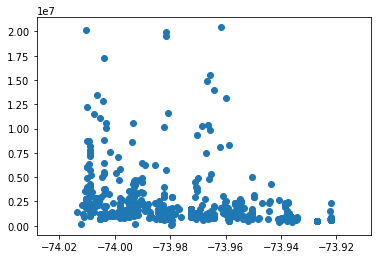

In [12]:
plt.scatter(M_df['longitude'], M_df['price'])
plt.show()

In [13]:
borough_gp = df.groupby('Borough')

In [14]:
price_by_borough = borough_gp['price'].count()
price_by_borough


Borough
Bk    1320
Bx     321
M     2411
Q      495
SI      96
Name: price, dtype: int64

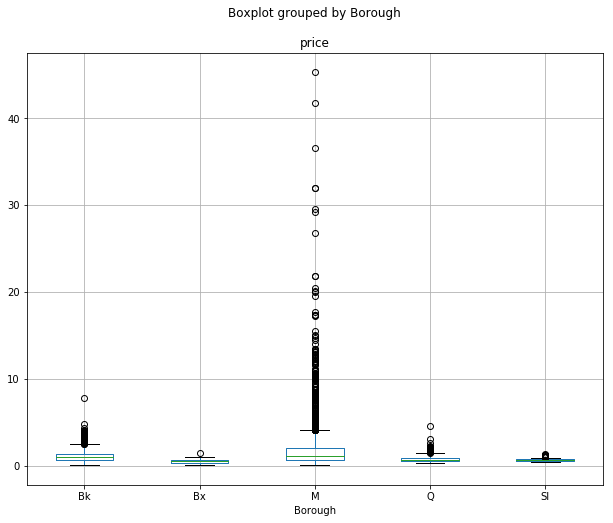

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('xxx')
ax = df.boxplot(column=['price'], by='Borough', ax=ax)


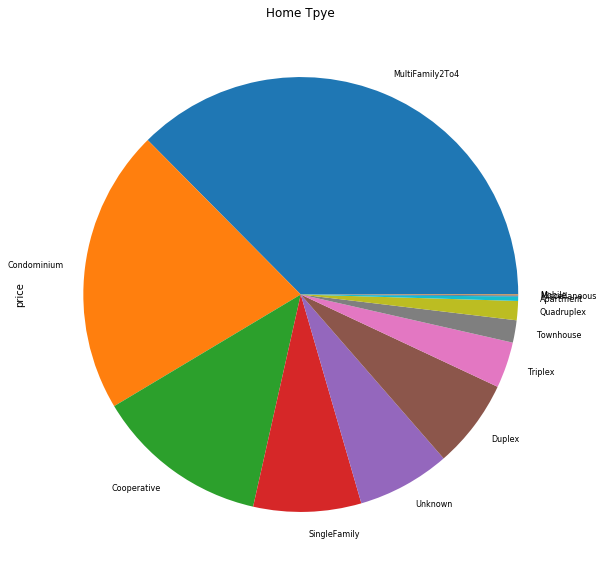

In [16]:
ax = df.groupby('usecode')['price'].count().sort_values(ascending=False).plot(kind='pie', title ="Home Tpye", figsize=(10, 10), legend=False, fontsize=8)
plt.show()


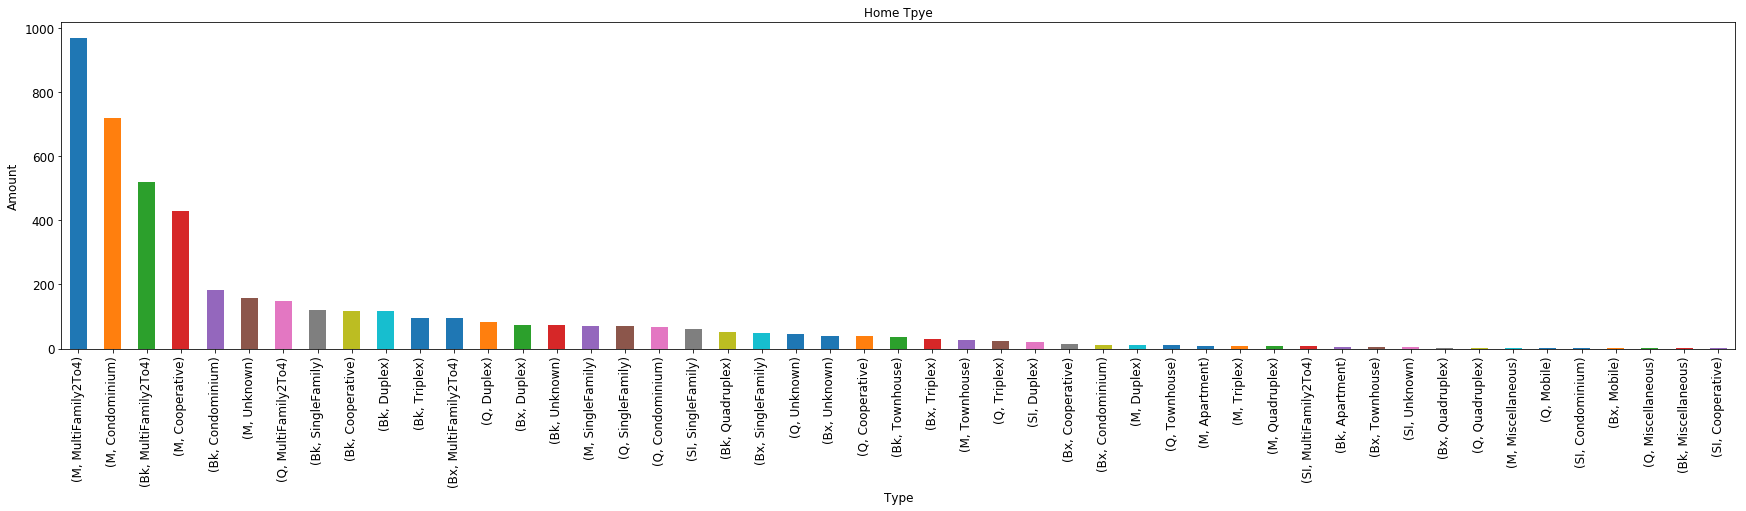

In [17]:
ax = df.groupby(['Borough', 'usecode'])['price'].count().sort_values(ascending=False).plot(kind='bar', title ="Home Tpye", figsize=(30, 6), legend=False, fontsize=12)
ax.set_xlabel("Type", fontsize=12)
ax.set_ylabel("Amount", fontsize=12)
plt.show()


In [18]:
df['distance_miles'].describe()

count    4643.000000
mean        0.082406
std         0.040577
min         0.000125
25%         0.046222
50%         0.085848
75%         0.117676
max         0.149906
Name: distance_miles, dtype: float64

In [19]:
len(df)


4643

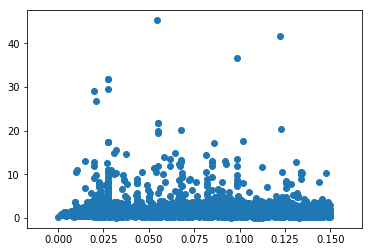

In [20]:
plt.scatter(df['distance_miles'], df['price'])
plt.show()

In [21]:
borough_house_type_gp = df.groupby(['Borough', 'usecode'])
borough_house_type_gp['price'].count()


Borough  usecode        
Bk       Apartment            6
         Condominium        182
         Cooperative        117
         Duplex             116
         Miscellaneous        1
         MultiFamily2To4    520
         Quadruplex          53
         SingleFamily       120
         Townhouse           35
         Triplex             97
         Unknown             73
Bx       Condominium         12
         Cooperative         14
         Duplex              75
         Mobile               1
         MultiFamily2To4     94
         Quadruplex           3
         SingleFamily        49
         Townhouse            4
         Triplex             29
         Unknown             40
M        Apartment            9
         Condominium        718
         Cooperative        429
         Duplex              11
         Miscellaneous        2
         MultiFamily2To4    969
         Quadruplex           7
         SingleFamily        72
         Townhouse           27
         Triple

In [22]:
df = df[df['lotSizeSqFt'] != 0]
df['price per sqft'] = df['price'] / df['lotSizeSqFt']
df = df[df['price per sqft'] < 6000]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


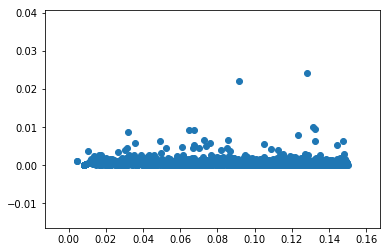

In [23]:
df.head()
plt.scatter(df['distance_miles'], df['price per sqft'])

In [24]:
df.shape

(1903, 16)

In [25]:
si_home = df[df['Borough'] == 'SI']
print(si_home.shape)
si_home.head()


(87, 16)


,Unnamed: 0,zpid,latitude,longitude,usecode,bathrooms,bedrooms,zipcode,price,lotSizeSqFt,Nearest Station Index,Nearest Station Lat,Nearest Station Lon,Borough,distance_miles,price per sqft
2944,4946,32324455,40.596302,-74.089586,SingleFamily,0.0,0,10304,0.844092,9800,481,40.596612,-74.087368,SI,0.118356,0.000086
2945,4947,32324506,40.596277,-74.088480,SingleFamily,0.0,0,10304,0.628001,5999,481,40.596612,-74.087368,SI,0.062783,0.000105
2946,4948,32324507,40.596303,-74.089009,SingleFamily,0.0,0,10304,0.765448,8400,481,40.596612,-74.087368,SI,0.088728,0.000091
3087,5121,32354518,40.545262,-74.164127,SingleFamily,2.0,3,10312,0.550732,6000,489,40.544601,-74.164570,SI,0.051268,0.000092
3088,5122,32354519,40.545478,-74.164173,SingleFamily,2.0,4,10312,0.739609,4800,489,40.544601,-74.164570,SI,0.064100,0.000154


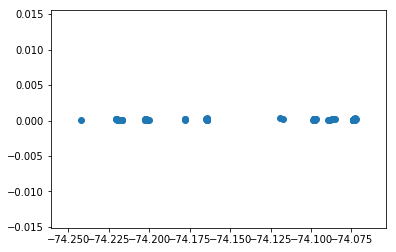

In [26]:
plt.scatter(si_home['longitude'], si_home['price per sqft'])

In [27]:
type_gp = si_home.groupby('usecode')
type_gp.count()


,Unnamed: 0,zpid,latitude,longitude,bathrooms,bedrooms,zipcode,price,lotSizeSqFt,Nearest Station Index,Nearest Station Lat,Nearest Station Lon,Borough,distance_miles,price per sqft
usecode,,,,,,,,,,,,,,,
Duplex,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
MultiFamily2To4,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
SingleFamily,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59


In [28]:
si_home_station = si_home.groupby('Nearest Station Index')

# only analysis home number > 20 around a station.
si_sta_index = [key for key,val in si_home_station['zpid'].count().iteritems() if val > 30]
si_sta_index


[]

In [29]:
si_home_station['zpid'].count()


Nearest Station Index
479    16
480     1
481     7
482    19
485     2
489    15
490     3
492     8
493    15
496     1
Name: zpid, dtype: int64

In [30]:
df = df.loc[df['Nearest Station Index'].isin(si_sta_index)]
df


,Unnamed: 0,zpid,latitude,longitude,usecode,bathrooms,bedrooms,zipcode,price,lotSizeSqFt,Nearest Station Index,Nearest Station Lat,Nearest Station Lon,Borough,distance_miles,price per sqft


In [31]:
singleFamily = si_home[(si_home['usecode'] == 'Condominium')]
singleFamily


,Unnamed: 0,zpid,latitude,longitude,usecode,bathrooms,bedrooms,zipcode,price,lotSizeSqFt,Nearest Station Index,Nearest Station Lat,Nearest Station Lon,Borough,distance_miles,price per sqft


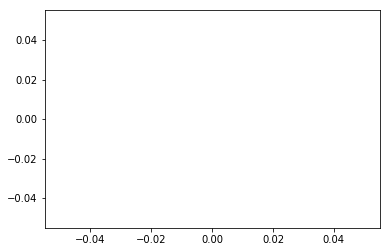

In [32]:
plt.scatter(singleFamily['longitude'], singleFamily['price per sqft'])
plt.show()


In [33]:
mta = mta[mta['Borough'] == 'SI']
station_layer = gmaps.symbol_layer(
    mta[["GTFS Latitude", "GTFS Longitude"]], fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=5,
)

home_layer = gmaps.symbol_layer(
    df[['latitude', 'longitude']], fill_color='rgba(150, 0, 0, 0.4)',
    stroke_color='rgba(150, 0, 0, 0.4)', scale=1,
)

fig = gmaps.figure()
fig.add_layer(station_layer)
fig.add_layer(home_layer)

fig


Figure(layout=FigureLayout(height='420px'))